In [5]:
import numpy as np
import pandas as pd
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [7]:
movies_data = pd.read_csv('movies.csv')

# Data collection and pre processing

In [10]:
# printing the first 5 rows of the dataframe
movies_data.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [12]:
# number of rows and columns in the data frame

movies_data.shape

(4803, 24)

In [14]:
# selecting the relevant features for recommendation

selected_features = ['genres','keywords','tagline','cast','director']
print(selected_features)

['genres', 'keywords', 'tagline', 'cast', 'director']


In [16]:
# replacing the null valuess with null string

for feature in selected_features:
  movies_data[feature] = movies_data[feature].fillna('')

In [18]:
# combining all the 5 selected features

combined_features = movies_data['genres']+' '+movies_data['keywords']+' '+movies_data['tagline']+' '+movies_data['cast']+' '+movies_data['director']

In [20]:
print(combined_features)

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states\u2013mexic...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object


# EDA(exploratory data analysis)

In [23]:
# Display basic information about the dataset
print("Dataset Shape:", movies_data.shape)
print("\nDataset Info:")
print(movies_data.info())
print("\nMissing Values:\n", movies_data.isnull().sum())

Dataset Shape: (4803, 24)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4803 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4803 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-

In [25]:
# Splitting the genres by '|' and counting each genre occurrence
all_genres = movies_data['genres'].str.split('|').explode()
genre_counts = all_genres.value_counts().head(10)  # Top 10 genres


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


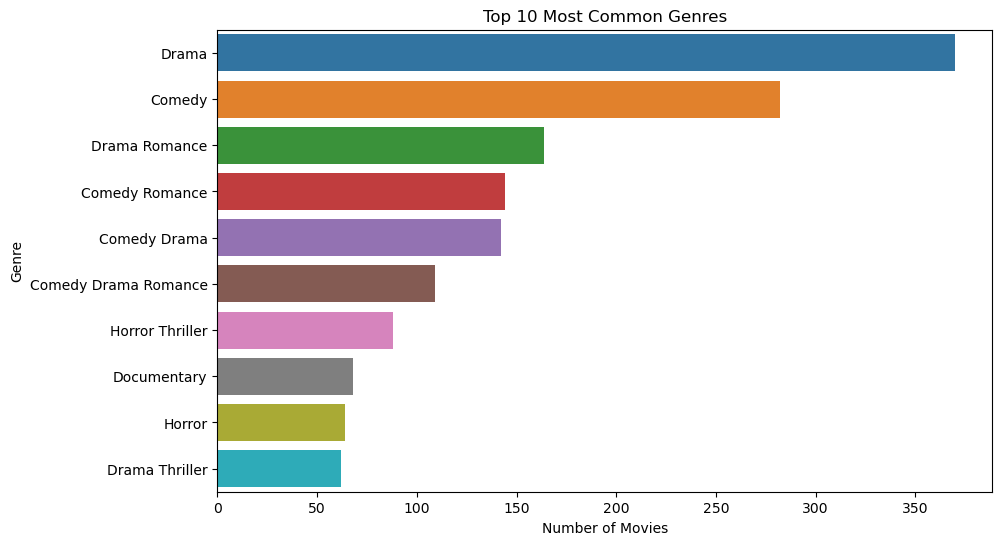

In [27]:
# 1. Distribution of Genres
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, hue=genre_counts.index, dodge=False)
plt.title("Top 10 Most Common Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.legend().set_visible(False)  # Hide the legend as it duplicates the y-axis labels
plt.show()

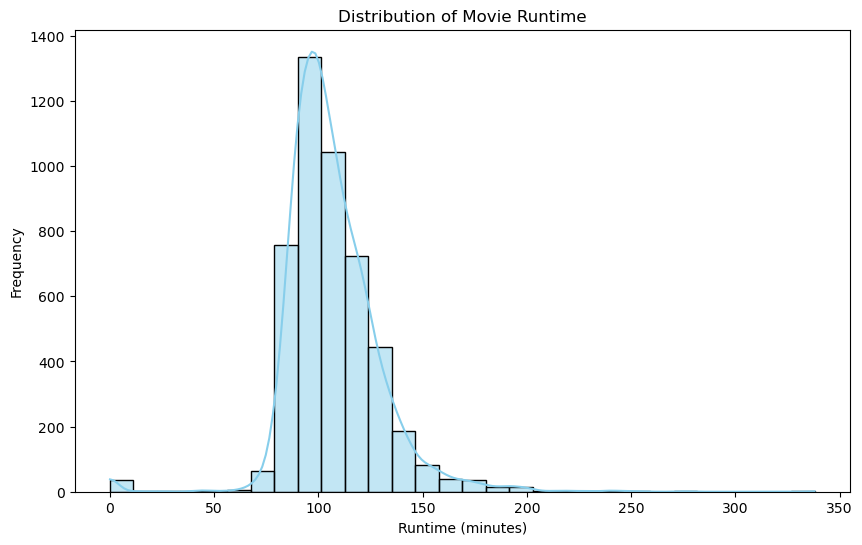

In [28]:
# 2. Runtime Distribution
plt.figure(figsize=(10, 6))
sns.histplot(movies_data['runtime'].dropna(), bins=30, kde=True, color="skyblue")
plt.title("Distribution of Movie Runtime")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Frequency")
plt.show()

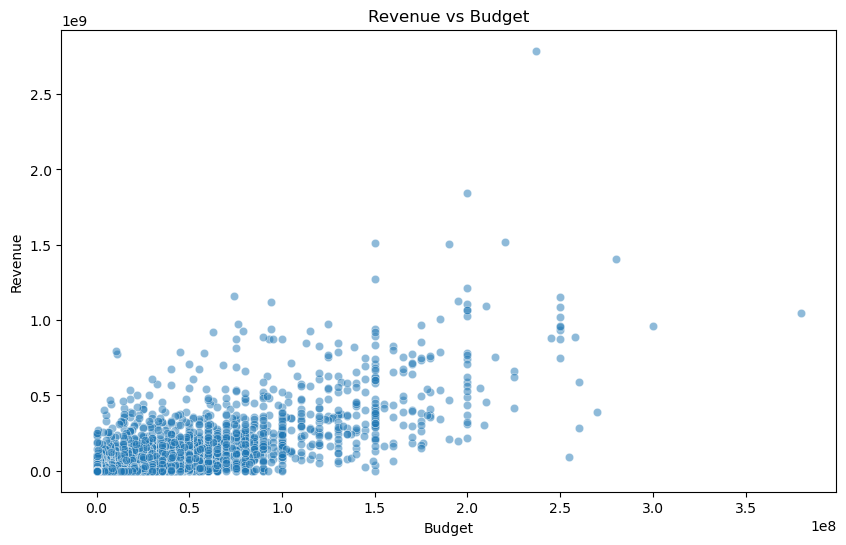

In [29]:
# 3. Revenue vs Budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x=movies_data['budget'], y=movies_data['revenue'], alpha=0.5)
plt.title("Revenue vs Budget")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

In [31]:
# Splitting the cast by '|' and counting each cast member occurrence
all_cast = movies_data['cast'].str.split('|').explode()
cast_counts = all_cast.value_counts().head(10)  # Top 10 cast members


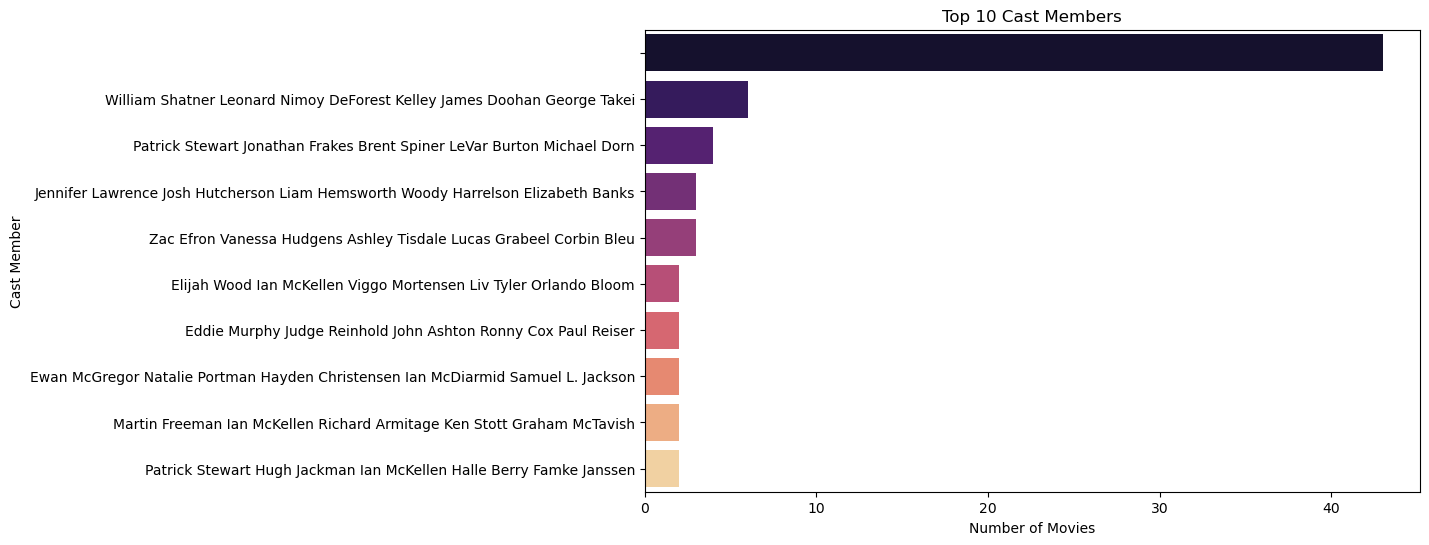

In [33]:
# 4. Top 10 Cast Members
plt.figure(figsize=(10, 6))
sns.barplot(x=cast_counts.values, y=cast_counts.index, hue=cast_counts.index, palette="magma", legend=False)
plt.title("Top 10 Cast Members")
plt.xlabel("Number of Movies")
plt.ylabel("Cast Member")
plt.show()

In [34]:
# Selecting the features to use for text similarity
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director']
print("\nSelected features for similarity analysis:", selected_features)



Selected features for similarity analysis: ['genres', 'keywords', 'tagline', 'cast', 'director']


In [37]:
print(combined_features)

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states\u2013mexic...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object


In [38]:
# converting the text data to feature vectors

vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)

In [42]:
# Display the shape of the feature vectors
print("\nTF-IDF Feature Vectors shape:", feature_vectors.shape)



TF-IDF Feature Vectors shape: (4803, 17318)


In [45]:
print(feature_vectors)

  (0, 2432)	0.17272411194153
  (0, 7755)	0.1128035714854756
  (0, 13024)	0.1942362060108871
  (0, 10229)	0.16058685400095302
  (0, 8756)	0.22709015857011816
  (0, 14608)	0.15150672398763912
  (0, 16668)	0.19843263965100372
  (0, 14064)	0.20596090415084142
  (0, 13319)	0.2177470539412484
  (0, 17290)	0.20197912553916567
  (0, 17007)	0.23643326319898797
  (0, 13349)	0.15021264094167086
  (0, 11503)	0.27211310056983656
  (0, 11192)	0.09049319826481456
  (0, 16998)	0.1282126322850579
  (0, 15261)	0.07095833561276566
  (0, 4945)	0.24025852494110758
  (0, 14271)	0.21392179219912877
  (0, 3225)	0.24960162956997736
  (0, 16587)	0.12549432354918996
  (0, 14378)	0.33962752210959823
  (0, 5836)	0.1646750903586285
  (0, 3065)	0.22208377802661425
  (0, 3678)	0.21392179219912877
  (0, 5437)	0.1036413987316636
  :	:
  (4801, 17266)	0.2886098184932947
  (4801, 4835)	0.24713765026963996
  (4801, 403)	0.17727585190343226
  (4801, 6935)	0.2886098184932947
  (4801, 11663)	0.21557500762727902
  (4801, 1672

# cosine similarity

In [48]:
# getting the similarity scores using cosine similarity

similarity = cosine_similarity(feature_vectors)

In [49]:
print(similarity)

[[1.         0.07219487 0.037733   ... 0.         0.         0.        ]
 [0.07219487 1.         0.03281499 ... 0.03575545 0.         0.        ]
 [0.037733   0.03281499 1.         ... 0.         0.05389661 0.        ]
 ...
 [0.         0.03575545 0.         ... 1.         0.         0.02651502]
 [0.         0.         0.05389661 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.02651502 0.         1.        ]]


In [50]:
# getting the movie name from the user

movie_name = input(' Enter your favourite movie name : ')

 Enter your favourite movie name :  charly


In [54]:
# creating a list with all the movie names given in the dataset

list_of_all_titles = movies_data['title'].tolist()
print(list_of_all_titles)

['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice', 'Superman Returns', 'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Man of Steel', 'The Chronicles of Narnia: Prince Caspian', 'The Avengers', 'Pirates of the Caribbean: On Stranger Tides', 'Men in Black 3', 'The Hobbit: The Battle of the Five Armies', 'The Amazing Spider-Man', 'Robin Hood', 'The Hobbit: The Desolation of Smaug', 'The Golden Compass', 'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship', 'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3', 'Alice in Wonderland', 'X-Men: The Last Stand', 'Monsters University', 'Transformers: Revenge of the Fallen', 'Transformers: Age of Extinction', 'Oz: The Great and Powerful', 'The Amazing Spider-Man 2', 'TRON: Legacy', 'Cars 2', 'Green Lant

In [56]:
# finding the close match for the movie name given by the user

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
print(find_close_match)

['Charly']


In [58]:
close_match = find_close_match[0]
print(close_match)

Charly


In [60]:
# finding the index of the movie with title

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]
print(index_of_the_movie)

4427


In [62]:
# getting a list of similar movies

similarity_score = list(enumerate(similarity[index_of_the_movie]))
print(similarity_score)

[(0, 0.0195753902093141), (1, 0.07650378947222214), (2, 0.031136030834732424), (3, 0.00322804684196043), (4, 0.019061487512500426), (5, 0.012382279947819425), (6, 0.0), (7, 0.019758817374715822), (8, 0.0), (9, 0.0), (10, 0.022017807361803508), (11, 0.010618336239393174), (12, 0.0449662816518415), (13, 0.0), (14, 0.04037380314976465), (15, 0.0), (16, 0.018735559001975252), (17, 0.0), (18, 0.018702738203149636), (19, 0.0), (20, 0.12790908746010515), (21, 0.0), (22, 0.0), (23, 0.06877870476562346), (24, 0.0027274144738792163), (25, 0.009828398117646405), (26, 0.020392817882159374), (27, 0.0466737662260823), (28, 0.01957765854258524), (29, 0.03184029754708402), (30, 0.012046735684891362), (31, 0.01923767019024097), (32, 0.0), (33, 0.019636049918860348), (34, 0.0), (35, 0.020612939658154587), (36, 0.018573903581950976), (37, 0.0), (38, 0.0), (39, 0.04667237313572731), (40, 0.0), (41, 0.018857204818206765), (42, 0.0), (43, 0.08255848547812726), (44, 0.0), (45, 0.02038043777729969), (46, 0.01

In [64]:
len(similarity_score)

4803

In [66]:
# sorting the movies based on their similarity score

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 
print(sorted_similar_movies)

[(4427, 1.0), (3338, 0.13228118658368357), (20, 0.12790908746010515), (269, 0.12426818683311987), (4332, 0.12324322903652116), (976, 0.11458296456840708), (4401, 0.10947160302653425), (159, 0.10339492817261244), (4745, 0.10145457997573605), (1902, 0.1001665481966367), (2129, 0.09962784544465572), (1395, 0.09931994196325909), (1763, 0.09821075187661947), (3987, 0.09804921293281023), (1238, 0.09714159970476018), (366, 0.09555629539203837), (734, 0.09537886265124945), (1997, 0.09326597299312905), (1642, 0.09197217909627152), (2207, 0.09136506173542996), (591, 0.09110484121866497), (1276, 0.09018066987032691), (2171, 0.08996716506201151), (2157, 0.08896598607641013), (3077, 0.08737484939922052), (3572, 0.08665658970066002), (123, 0.08371569704578034), (310, 0.08352815083039576), (4661, 0.08267415419237303), (1085, 0.08264517716308713), (43, 0.08255848547812726), (93, 0.08216374050796603), (4742, 0.08201835773950837), (409, 0.08119874886053972), (1595, 0.08097582018797173), (1302, 0.0806331

In [68]:
# print the name of similar movies based on the index

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if (i<30):
    print(i, '.',title_from_index)
    i+=1

Movies suggested for you : 

1 . Charly
2 . Flashdance
3 . The Amazing Spider-Man
4 . The Princess and the Frog
5 . Silent Running
6 . Escape from L.A.
7 . The Helix... Loaded
8 . Spider-Man
9 . The Brain That Wouldn't Die
10 . The Box
11 . The Black Hole
12 . Resident Evil
13 . The Duchess
14 . Young Frankenstein
15 . The Island of Dr. Moreau
16 . Hollow Man
17 . The Tale of Despereaux
18 . Her
19 . Splice
20 . 12 Rounds
21 . Stardust
22 . A Thousand Words
23 . My Best Friend's Girl
24 . Daybreakers
25 . Malone
26 . The Lazarus Effect
27 . The Matrix Revolutions
28 . In the Heart of the Sea
29 . The Big Parade


# movie recomendation system

In [70]:
movie_name = input(' Enter your favourite movie name : ')

list_of_all_titles = movies_data['title'].tolist()

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

close_match = find_close_match[0]

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]

similarity_score = list(enumerate(similarity[index_of_the_movie]))

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
    index = movie[0]
    title_from_index = movies_data[movies_data.index==index]['title'].values[0]
    if (i<30):
        print(i, '.',title_from_index)
        i+=1


 Enter your favourite movie name :  batman


Movies suggested for you : 

1 . Batman
2 . Batman Returns
3 . Batman & Robin
4 . The Dark Knight Rises
5 . Batman Begins
6 . The Dark Knight
7 . A History of Violence
8 . Superman
9 . Beetlejuice
10 . Bedazzled
11 . Mars Attacks!
12 . The Sentinel
13 . Planet of the Apes
14 . Man of Steel
15 . Suicide Squad
16 . The Mask
17 . Salton Sea
18 . Spider-Man 3
19 . The Postman Always Rings Twice
20 . Hang 'em High
21 . Spider-Man 2
22 . Dungeons & Dragons: Wrath of the Dragon God
23 . Superman Returns
24 . Jonah Hex
25 . Exorcist II: The Heretic
26 . Superman II
27 . Green Lantern
28 . Superman III
29 . Something's Gotta Give


In [71]:

def recommend_movies(movie_name, num_recommendations=10):
    # Create a list of all movie titles
    list_of_all_titles = movies_data['title'].tolist()
    
    # Find close match
    find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
    
    if not find_close_match:
        print("Sorry, no close match found for your movie.")
        return
    
    close_match = find_close_match[0]
    index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]
    
    # Get similarity scores
    similarity_score = list(enumerate(similarity[index_of_the_movie]))
    
    # Sort movies based on similarity scores
    sorted_similar_movies = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    print(f'Movies suggested for you based for you:')
    
    # Print the top N similar movies
    for i, movie in enumerate(sorted_similar_movies[1:num_recommendations + 1]):  # Skip the first one as it's the movie itself
        index = movie[0]
        title_from_index = movies_data[movies_data.index == index]['title'].values[0]
        print(f"{i + 1}. {title_from_index}")

# Get user input and recommend movies
movie_name = input('Enter your favorite movie name: ')
num_recommendations = int(input('How many recommendations would you like? '))
recommend_movies(movie_name, num_recommendations)

Enter your favorite movie name:  batman
How many recommendations would you like?  5


Movies suggested for you based for you:
1. Batman Returns
2. Batman & Robin
3. The Dark Knight Rises
4. Batman Begins
5. The Dark Knight


Movie Recommendation System



Enter a movie title (or 'quit' to exit):  batman
How many recommendations would you like?  5



Top Recommendations:

Title: the dark knight
Vote Average: 8.2
Vote Count: 12002
Similarity Score: 0.353
Final Score: 2.623
--------------------------------------------------

Title: the dark knight rises
Vote Average: 7.6
Vote Count: 9106
Similarity Score: 0.353
Final Score: 2.451
--------------------------------------------------

Title: batman begins
Vote Average: 7.5
Vote Count: 7359
Similarity Score: 0.353
Final Score: 2.413
--------------------------------------------------

Title: man of steel
Vote Average: 6.5
Vote Count: 6359
Similarity Score: 0.235
Final Score: 2.087
--------------------------------------------------

Title: underworld
Vote Average: 6.6
Vote Count: 2512
Similarity Score: 0.224
Final Score: 2.072
--------------------------------------------------


<Figure size 1200x800 with 0 Axes>

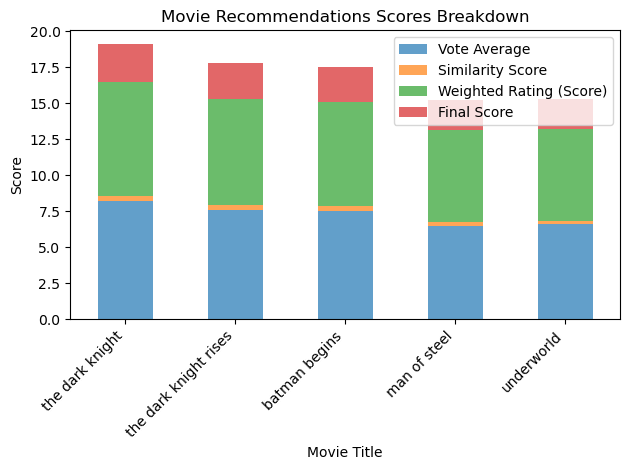


Enter a movie title (or 'quit' to exit):  quit


In [79]:

movies_data['title'] = movies_data['title'].str.strip().str.lower()

# Calculate weighted rating
def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

# Create a hybrid recommendation system
def hybrid_recommender():
    # Calculate vote count threshold (90th percentile)
    m = movies_data['vote_count'].quantile(0.9)

    # Calculate mean vote average
    C = movies_data['vote_average'].mean()

    # Filter movies based on vote count threshold
    qualified = movies_data.copy().loc[movies_data['vote_count'] >= m]

    # Calculate weighted ratings
    qualified['score'] = qualified.apply(lambda x: weighted_rating(x, m, C), axis=1)

    # Normalize budget and revenue
    scaler = MinMaxScaler()
    qualified[['budget_normalized', 'revenue_normalized']] = scaler.fit_transform(
        qualified[['budget', 'revenue']]
    )

    # Create content features
    qualified['content'] = (
        qualified['genres'] + ' ' +
        qualified['keywords'] + ' ' +
        qualified['director'] + ' ' +
        qualified['cast']
    )

    # Create count vectors
    count = CountVectorizer(stop_words='english')
    count_matrix = count.fit_transform(qualified['content'])

    # Calculate cosine similarity
    cosine_sim = cosine_similarity(count_matrix, count_matrix)

    # Reset index
    qualified = qualified.reset_index()
    indices = pd.Series(qualified.index, index=qualified['title'])

    return qualified, cosine_sim, indices

def get_recommendations(title, qualified, cosine_sim, indices, n=10):
    # Normalize the input title
    title = title.strip().lower()  # Trim whitespace and convert to lowercase
    try:
        # Get the index of the movie
        idx = indices[title]

        # Get similarity scores
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Sort movies based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get top N most similar movies
        sim_scores = sim_scores[1:n + 1]

        # Get movie indices
        movie_indices = [i[0] for i in sim_scores]

        # Return the top N most similar movies with their scores
        recommendations = qualified.iloc[movie_indices][['title', 'score', 'vote_average', 'vote_count']]
        recommendations['similarity_score'] = [i[1] for i in sim_scores]

        # Calculate final score (combining weighted rating and similarity)
        recommendations['final_score'] = (recommendations['score'] * 0.3 +
                                           recommendations['similarity_score'] * 0.7)

        # Sort by final score
        recommendations = recommendations.sort_values('final_score', ascending=False)

        return recommendations

    except KeyError:
        print(f"Movie '{title}' not found in database.")
        return None

# Function to display recommendations with additional information
def display_recommendations(recommendations):
    if recommendations is not None:
        print("\nTop Recommendations:")
        print("===================")
        for idx, row in recommendations.iterrows():
            print(f"\nTitle: {row['title']}")
            print(f"Vote Average: {row['vote_average']:.1f}")
            print(f"Vote Count: {int(row['vote_count'])}")
            print(f"Similarity Score: {row['similarity_score']:.3f}")
            print(f"Final Score: {row['final_score']:.3f}")
            print("-" * 50)

# Interactive recommendation function with visualization
def get_movie_recommendations():
    while True:
        # Get user input
        movie_title = input("\nEnter a movie title (or 'quit' to exit): ")

        if movie_title.lower() == 'quit':
            break

        # Normalize the input movie title
        movie_title = movie_title.strip().lower()

        # Get number of recommendations
        while True:
            try:
                n_recommendations = int(input("How many recommendations would you like? "))
                if n_recommendations <= 0:
                    raise ValueError("The number of recommendations must be positive.")
                break
            except ValueError as e:
                print(f"Invalid input: {e}. Please enter a positive integer.")

        # Get and display recommendations
        recommendations = get_recommendations(movie_title, qualified, cosine_sim, indices, n_recommendations)
        display_recommendations(recommendations)
        
        # Call visualize_recommendations to plot the results
        visualize_recommendations(recommendations)

# Visualization of recommendation results with stacked bar chart
def visualize_recommendations(recommendations):
    if recommendations is not None:
        plt.figure(figsize=(12, 8))

        # Stacked bar plot for each component score and final score
        recommendations.plot(
            kind="bar", 
            x="title", 
            stacked=True,
            color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
            y=["vote_average", "similarity_score", "score", "final_score"],
            alpha=0.7,
            legend=True
        )

        plt.title('Movie Recommendations Scores Breakdown')
        plt.xlabel('Movie Title')
        plt.ylabel('Score')
        plt.xticks(rotation=45, ha="right")
        plt.legend(['Vote Average', 'Similarity Score', 'Weighted Rating (Score)', 'Final Score'])
        plt.tight_layout()
        
        # Show the plot
        plt.show()

# Create the recommendation system
qualified, cosine_sim, indices = hybrid_recommender()

# Example usage
if __name__ == "__main__":
    print("Movie Recommendation System")
    print("==========================")
    get_movie_recommendations()
